# Component 07: EfficientNetB0 (Advanced Training)

✅ AdamW + Weight Decay | ✅ Cosine Annealing + Warmup | ✅ Label Smoothing | ✅ Mixed Precision

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, os, math
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

OUTPUT_DIR = '../outputs'
os.makedirs(f'{OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/training_history', exist_ok=True)
print('✅ Mixed precision enabled')

✅ Mixed precision enabled


## Config & Data

In [2]:
train_df = pd.read_csv('../outputs/train_manifest.csv')
val_df = pd.read_csv('../outputs/val_manifest.csv')

IMG_SIZE, BATCH_SIZE, EPOCHS = (224, 224), 32, 50
NUM_CLASSES = len(train_df['class_label'].unique())
INITIAL_LR, WEIGHT_DECAY, WARMUP_EPOCHS = 1e-3, 1e-4, 5
LABEL_SMOOTHING, GRADIENT_CLIP_NORM = 0.1, 1.0
DROPOUT_RATE_1 = 0.3  # First dropout layer
DROPOUT_RATE_2 = 0.4  # Second dropout layer
DROPOUT_RATE_3 = 0.5  # Final dropout layer

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Classes: {NUM_CLASSES}')
print(f'Hyperparams: LR={INITIAL_LR}, WD={WEIGHT_DECAY}, Warmup={WARMUP_EPOCHS}, LS={LABEL_SMOOTHING}')

Train: 8220, Val: 1761, Classes: 4
Hyperparams: LR=0.001, WD=0.0001, Warmup=5, LS=0.1


## Preprocessing

In [3]:
def preprocess(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

aug = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.15), tf.keras.layers.RandomZoom(0.2)])

def build_dataset(df, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['class_label'].values))
    ds = ds.map(preprocess, tf.data.AUTOTUNE).cache()
    if augment:
        ds = ds.map(lambda x, y: (aug(x, training=True), y))
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds, val_ds = build_dataset(train_df, augment=True), build_dataset(val_df, augment=False, shuffle=False)
print('✅ Datasets ready')

2026-01-30 15:35:05.359653: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-30 15:35:05.359724: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-30 15:35:05.359740: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-30 15:35:05.359962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-30 15:35:05.359975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Datasets ready


## Build EfficientNetB0

In [6]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)

# Freeze all layers except the last 30
for layer in base.layers[:-30]:
    layer.trainable = False

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))

# Forward pass
x = base(inputs, training=True)
x = tf.keras.layers.Dropout(DROPOUT_RATE_1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE_2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE_3)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,919 (16.83 MB)

 Trainable params: 1,855,204 (7.08 MB)

 Non-trainable params: 2,555,715 (9.75 MB)

## Compile

In [7]:
def get_lr_schedule(epoch, lr):
    if epoch < WARMUP_EPOCHS:
        return INITIAL_LR * (epoch + 1) / WARMUP_EPOCHS
    progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
    return INITIAL_LR * 0.5 * (1 + math.cos(math.pi * progress))

In [8]:
# Custom Label Smoothing Loss (Compatible with all TF versions)
class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, self.num_classes)
        y_true_smooth = y_true_one_hot * (1 - self.smoothing) + self.smoothing / self.num_classes
        return tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred)

loss_fn = LabelSmoothingLoss(NUM_CLASSES, smoothing=LABEL_SMOOTHING)
print(f'✅ Label Smoothing Loss created (ε={LABEL_SMOOTHING})')

✅ Label Smoothing Loss created (ε=0.1)


In [9]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class_label']), y=train_df['class_label'])
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

optimizer = tf.keras.optimizers.AdamW(learning_rate=INITIAL_LR, weight_decay=WEIGHT_DECAY, clipnorm=GRADIENT_CLIP_NORM)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
print('✅ Compiled with AdamW + Custom Label Smoothing')

✅ Compiled with AdamW + Custom Label Smoothing


## Train

In [10]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f'{OUTPUT_DIR}/models/efficientnetb0_best.h5', monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(get_lr_schedule, verbose=1),
    tf.keras.callbacks.CSVLogger(f'{OUTPUT_DIR}/training_history/efficientnetb0_training.csv')
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weight_dict)
with open(f'{OUTPUT_DIR}/training_history/efficientnetb0_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f)
print(f'✅ Best Val Acc: {max(history.history["val_accuracy"]):.4f}')


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/50


2026-01-30 15:37:37.776639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5092 - loss: 1.2744

257/257 ━━━━━━━━━━━━━━━━━━━━ 198s 713ms/step - accuracy: 0.5777 - loss: 1.1562 - val_accuracy: 0.6099 - val_loss: 1.0905 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.6191 - loss: 1.0991

257/257 ━━━━━━━━━━━━━━━━━━━━ 218s 825ms/step - accuracy: 0.6279 - loss: 1.1509 - val_accuracy: 0.7195 - val_loss: 0.8906 - learning_rate: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 157s 593ms/step - accuracy: 0.6324 - loss: 1.1856 - val_accuracy: 0.6843 - val_loss: 0.9405 - learning_rate: 6.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008.
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6418 - loss: 1.1637

257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 567ms/step - accuracy: 0.6401 - loss: 1.1752 - val_accuracy: 0.7274 - val_loss: 0.9148 - learning_rate: 8.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 158s 600ms/step - accuracy: 0.6258 - loss: 1.6316 - val_accuracy: 0.5724 - val_loss: 1.1956 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 148s 563ms/step - accuracy: 0.6448 - loss: 1.5052 - val_accuracy: 0.6564 - val_loss: 2.3702 - learning_rate: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0009987820251299122.
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 564ms/step - accuracy: 0.6431 - loss: 3.0948 - val_accuracy: 0.6661 - val_loss: 1.2433 - learning_rate: 9.9878e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0009951340343707852.
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 156s 592ms/step - accuracy: 0.6333 - loss: 4.3563 -

257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 565ms/step - accuracy: 0.6695 - loss: 1.2462 - val_accuracy: 0.7700 - val_loss: 0.7747 - learning_rate: 9.5677e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0009414737964294635.
Epoch 13/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 150s 568ms/step - accuracy: 0.6426 - loss: 2.5731 - val_accuracy: 0.5576 - val_loss: 1.1162 - learning_rate: 9.4147e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0009240240480782129.
Epoch 14/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 148s 564ms/step - accuracy: 0.6371 - loss: 4.5135 - val_accuracy: 0.6542 - val_loss: 1.1644 - learning_rate: 9.2402e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0009045084971874737.
Epoch 15/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 565ms/step - accuracy: 0.6400 - loss: 4.8888 - val_accuracy: 0.5752 - val_loss: 1.1941 - learning_rate: 9.0451e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.000883022221559489.
Epoch 16/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 148s

2026-01-30 17:06:38.308398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 876 of 1000
2026-01-30 17:06:39.469764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


257/257 ━━━━━━━━━━━━━━━━━━━━ 713s 3s/step - accuracy: 0.6347 - loss: 9.9201 - val_accuracy: 0.6212 - val_loss: 4.4066 - learning_rate: 4.8255e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.00044773576836617336.
Epoch 30/50


2026-01-30 17:18:31.801554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 965 of 1000
2026-01-30 17:18:32.164828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6269 - loss: 8.3708

257/257 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.6354 - loss: 8.7816 - val_accuracy: 0.7842 - val_loss: 1.1972 - learning_rate: 4.4774e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.00041317591116653486.
Epoch 31/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6466 - loss: 9.9673 - val_accuracy: 0.6962 - val_loss: 1.5924 - learning_rate: 4.1318e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0003790390522001662.
Epoch 32/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1104s 4s/step - accuracy: 0.6392 - loss: 9.8114 - val_accuracy: 0.6843 - val_loss: 1.4922 - learning_rate: 3.7904e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.00034549150281252633.
Epoch 33/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 716s 3s/step - accuracy: 0.6421 - loss: 8.2100 - val_accuracy: 0.7706 - val_loss: 1.1468 - learning_rate: 3.4549e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.00031269670329204396.
Epoch 34/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 676s 3s/ste

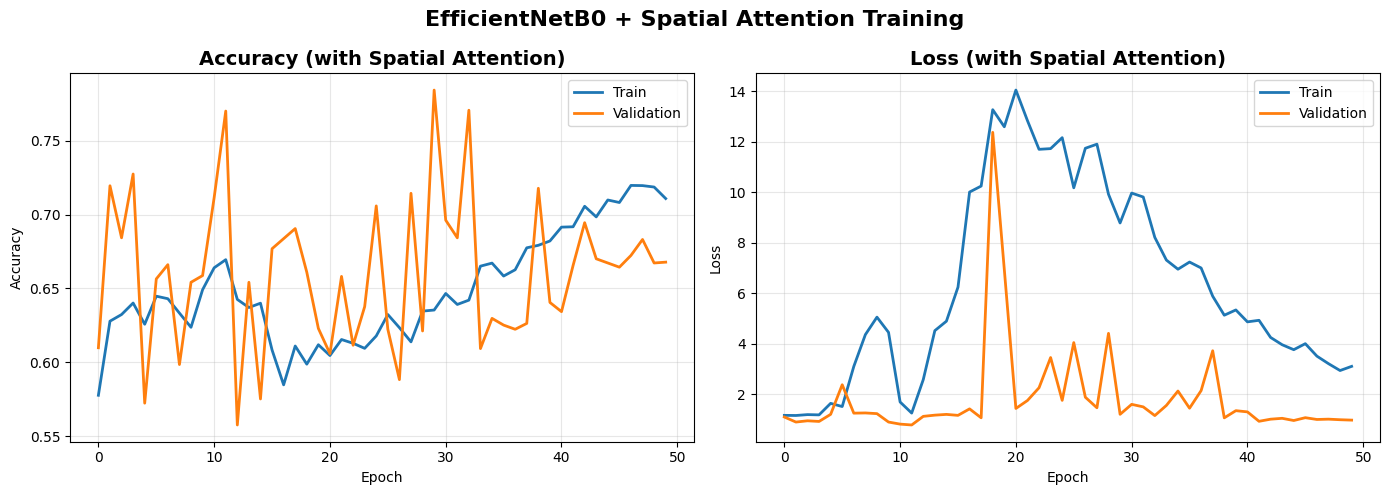


📊 Results:
   Best Val Accuracy: 0.7842
   Final Train Acc: 0.7108
   Final Val Acc: 0.6678

💾 Saved to: ../outputs/models/efficientnetb0_attention_best.h5

🔬 Compare with base EfficientNetB0 to measure attention impact!


In [11]:
# Save history
with open(f'{OUTPUT_DIR}/training_history/efficientnetb0_attention_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f, indent=2)

import pandas as pd
pd.DataFrame(history.history).to_csv(f'{OUTPUT_DIR}/training_history/efficientnetb0_attention_history.csv', index=False)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Accuracy (with Spatial Attention)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Loss (with Spatial Attention)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle(f'EfficientNetB0 + Spatial Attention Training', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history/efficientnetb0_attention_curves.png', dpi=200)
plt.show()

print(f'\n📊 Results:')
print(f'   Best Val Accuracy: {max(history.history["val_accuracy"]):.4f}')
print(f'   Final Train Acc: {history.history["accuracy"][-1]:.4f}')
print(f'   Final Val Acc: {history.history["val_accuracy"][-1]:.4f}')
print(f'\n💾 Saved to: {OUTPUT_DIR}/models/efficientnetb0_attention_best.h5')
print(f'\n🔬 Compare with base EfficientNetB0 to measure attention impact!')

In [ ]:
# Save history
with open(f'{OUTPUT_DIR}/training_history/efficientnetb0_attention_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f, indent=2)

import pandas as pd
pd.DataFrame(history.history).to_csv(f'{OUTPUT_DIR}/training_history/efficientnetb0_attention_history.csv', index=False)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Accuracy (with Spatial Attention)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Loss (with Spatial Attention)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle(f'EfficientNetB0 + Spatial Attention Training', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history/efficientnetb0_attention_curves.png', dpi=200)
plt.show()

print(f'\n📊 Results:')
print(f'   Best Val Accuracy: {max(history.history["val_accuracy"]):.4f}')
print(f'   Final Train Acc: {history.history["accuracy"][-1]:.4f}')
print(f'   Final Val Acc: {history.history["val_accuracy"][-1]:.4f}')
print(f'\n💾 Saved to: {OUTPUT_DIR}/models/efficientnetb0_attention_best.h5')
print(f'\n🔬 Compare with base EfficientNetB0 to measure attention impact!')